In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load dataset
radi = pd.read_csv("sbsppdaa24/train_radiomics_hipocamp.csv")

# Drop unique identifier columns
radi.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in radi.columns if radi[col].dtype == 'object' and col != 'Transition']
radi.drop(columns=columns_to_drop, inplace=True)

# Apply MinMax scaling to columns
float_cols = radi.select_dtypes(include=['float','int']).columns
scaler = MinMaxScaler()
radi[float_cols] = scaler.fit_transform(radi[float_cols])

# Intantiate Report
classification_reports = {}

# Check final dataset
radi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2162 entries, diagnostics_Image-original_Dimensionality to Transition
dtypes: float64(2161), object(1)
memory usage: 5.0+ MB


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score


In [5]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

bagging_params = {"n_estimators": [100, 500, 800, 1000]}
bagging_model = BaggingClassifier(random_state=2025)
bagging_grid = GridSearchCV(bagging_model, bagging_params, scoring='f1_micro', cv=skf, n_jobs=-1)
bagging_grid.fit(X_train, y_train)
y_pred_bagging = bagging_grid.best_estimator_.predict(X_test)
classification_reports["Bagging"] = classification_report(y_test, y_pred_bagging, output_dict=True)
print(f"Best Bagging Model Parameters: {bagging_grid.best_params_}")
print(f"Bagging Classification Report:\n", classification_report(y_test, y_pred_bagging))

NameError: name 'skf' is not defined

## Random Forest

In [42]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)
rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

# model, params, scoring using f1, 5 folds, full processor
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
classification_reports["RandomForest"] = classification_report(y_test, y_pred_rf, output_dict=True)
print(f"RandomForest Classification Report:\n", classification_report(y_test, y_pred_rf))

RandomForest Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.45      0.33      0.38        15
       CN-CN       0.53      0.83      0.65        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.32      0.35      0.33        17
     MCI-MCI       0.44      0.22      0.30        18

    accuracy                           0.45        77
   macro avg       0.35      0.35      0.33        77
weighted avg       0.43      0.45      0.42        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Gradient Boosting

In [43]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)
gbparams_model.fit(X_train, y_train)
y_pred_gbparams = gbparams_model.predict(X_test)
classification_reports["GradientBoosting"] = classification_report(y_test, y_pred_gbparams, output_dict=True)
print(f"GradientBoosting Classification Report:\n", classification_report(y_test, y_pred_gbparams))


GradientBoosting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.29      0.27      0.28        15
       CN-CN       0.64      0.75      0.69        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.29      0.24      0.26        17
     MCI-MCI       0.30      0.33      0.32        18

    accuracy                           0.42        77
   macro avg       0.30      0.32      0.31        77
weighted avg       0.39      0.42      0.40        77



In [15]:
from sklearn.preprocessing import LabelEncoder

# Copy the dataframe and apply label encoding to the target variable
df = radi.copy()
label_encoder = LabelEncoder()
df['Transition'] = label_encoder.fit_transform(df['Transition'])

# Define features and target
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Define XGBoost hyperparameters and model with a multi-class objective and compatible eval_metric
xgb_params = {
    "n_estimators": [500,800,1000],
    "learning_rate": [0.1,0.3,0.01],
    "max_depth": [5,6,8,20,0],
    
}

xgb_model = XGBClassifier(eval_metric='mlogloss',random_state=2025)

# Run GridSearchCV to find the best parameters
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
classification_reports["XGBoost"] = classification_report(y_test, y_pred_xgb, output_dict=True)
print(f"Best XGBoost Model Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


NameError: name 'skf' is not defined

## SVM

In [45]:
from sklearn.svm import SVC

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

# Initialize the SVC model
svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
classification_reports["SVM"] = classification_report(y_test, y_pred_svm, output_dict=True)
print(f"SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.32      0.40      0.35        15
       CN-CN       0.63      0.71      0.67        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.24      0.24      0.24        17
     MCI-MCI       0.46      0.33      0.39        18

    accuracy                           0.43        77
   macro avg       0.33      0.34      0.33        77
weighted avg       0.42      0.43      0.42        77



## Stacking

In [18]:
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")

meta_model = GradientBoostingClassifier(random_state=25)
meta_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=25)
xgb_model = XGBClassifier(random_state=2025)
"""
Modelo Melhor até agora 0.419
"""

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)

"""
meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)


dt_model = DecisionTreeClassifier()

estimators2 = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model),("dt",dt_model)]
st_model2 = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
st_model2.fit(X_train, y_train)
st_predictions2 = st_model2.predict(X_test)
"""

print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions))
# print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions2))

Stacking Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.43      0.40      0.41        15
       CN-CN       0.62      0.67      0.64        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.26      0.29      0.28        17
     MCI-MCI       0.39      0.39      0.39        18

    accuracy                           0.44        77
   macro avg       0.34      0.35      0.34        77
weighted avg       0.42      0.44      0.43        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [7]:
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")

xgb_model = XGBClassifier(random_state=2025)

meta_model = GradientBoostingClassifier(random_state=25)
meta_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=25)
xgb_model = XGBClassifier(random_state=2025)

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model), ("xgb",xgb_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)

"""
meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)


dt_model = DecisionTreeClassifier()

estimators2 = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model),("dt",dt_model)]
st_model2 = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
st_model2.fit(X_train, y_train)
st_predictions2 = st_model2.predict(X_test)
"""

print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions))
# print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions2))

Stacking Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.43      0.40      0.41        15
       CN-CN       0.63      0.71      0.67        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.24      0.24      0.24        17
     MCI-MCI       0.37      0.39      0.38        18

    accuracy                           0.44        77
   macro avg       0.33      0.35      0.34        77
weighted avg       0.42      0.44      0.43        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [8]:
# Com smote
from imblearn.over_sampling import SMOTE

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=2025)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")

xgb_model = XGBClassifier(random_state=2025)

meta_model = GradientBoostingClassifier(random_state=25)
meta_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=25)
xgb_model = XGBClassifier(random_state=2025)

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model), ("xgb",xgb_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train_resampled, y_train_resampled)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)

"""
meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True)


dt_model = DecisionTreeClassifier()

estimators2 = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model),("dt",dt_model)]
st_model2 = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
st_model2.fit(X_train, y_train)
st_predictions2 = st_model2.predict(X_test)
"""

print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions))
# print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions2))


Stacking Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.38      0.40      0.39        15
       CN-CN       0.53      0.83      0.65        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.35      0.35      0.35        17
     MCI-MCI       0.67      0.22      0.33        18

    accuracy                           0.47        77
   macro avg       0.38      0.36      0.34        77
weighted avg       0.47      0.47      0.43        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Max Voting

In [51]:
from sklearn.ensemble import VotingClassifier

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025, stratify=y)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [2,1,1]) 
vt_model.fit(X_train, y_train)
vt_predictions = vt_model.predict(X_test)
classification_reports["Voting"] = classification_report(y_test, vt_predictions, output_dict=True)
print(f"Voting Classification Report:\n", classification_report(y_test, st_predictions))

Voting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.39      0.47      0.42        15
       CN-CN       0.48      0.50      0.49        24
      CN-MCI       0.00      0.00      0.00         3
      MCI-AD       0.35      0.35      0.35        17
     MCI-MCI       0.40      0.33      0.36        18

    accuracy                           0.40        77
   macro avg       0.32      0.33      0.33        77
weighted avg       0.40      0.40      0.40        77



## Ver Resultados

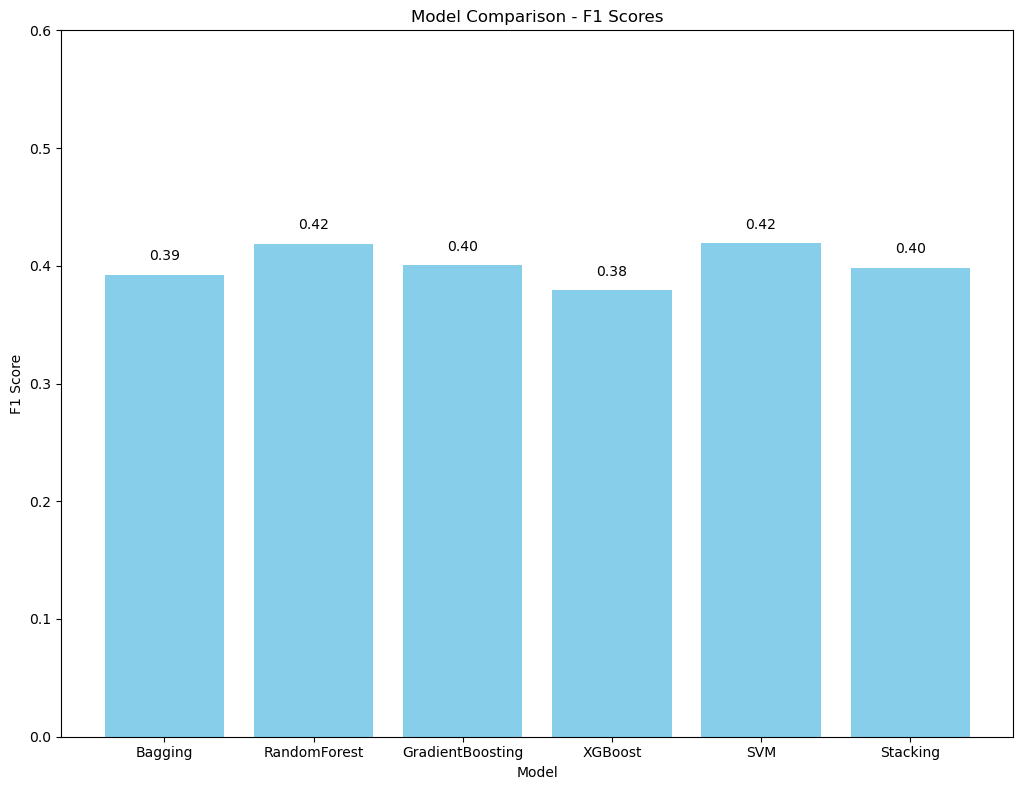

In [49]:
import matplotlib.pyplot as plt

# Assuming f1_scores is already defined
f1_scores = {model: report["weighted avg"]["f1-score"] for model, report in classification_reports.items()}

# Plotting
plt.figure(figsize=(20, 8))

# F1 Score Graph
plt.subplot(1, 2, 1)
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Model Comparison - F1 Scores")
plt.ylim(0, 0.6)

# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


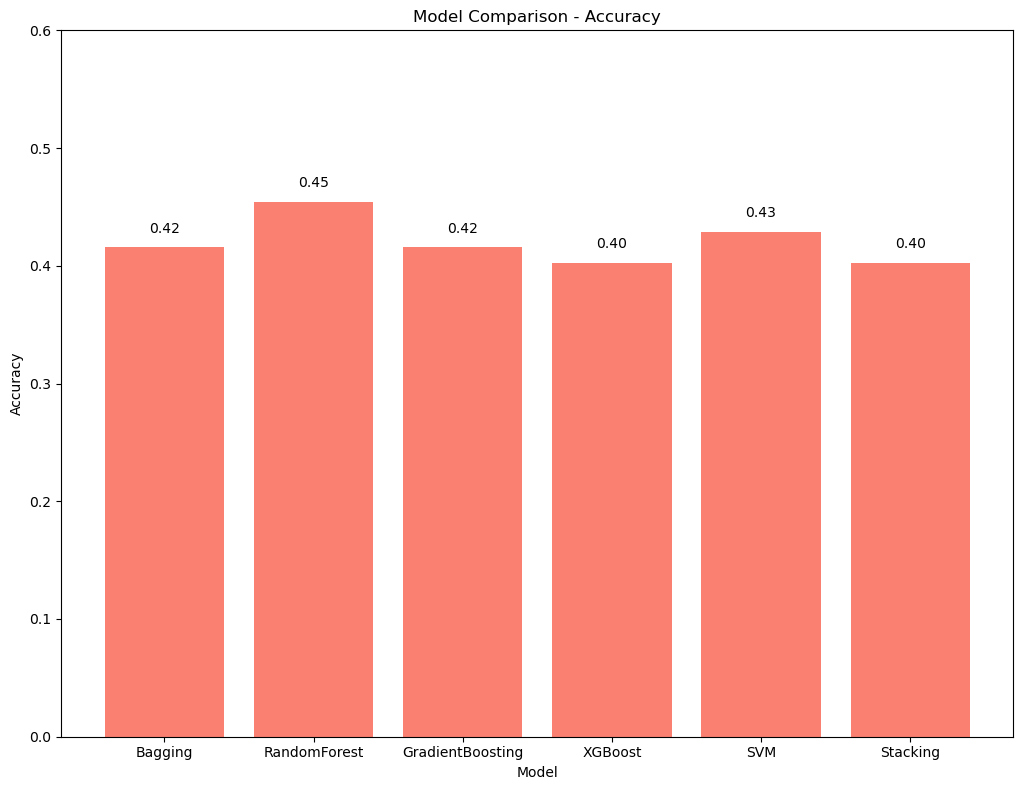

In [50]:
accuracies = {model: report["accuracy"] for model, report in classification_reports.items()}

# Accuracy Graph
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
bars = plt.bar(accuracies.keys(), accuracies.values(), color='salmon')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.ylim(0, 0.6)


# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Generating csv

In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unique identifier columns
test_data.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Ensure 'columns_to_drop' is available for test data
# If you haven't redefined this variable, you need to redo this step for the test set.
# Use the same method to identify non-numeric columns for dropping
non_numeric_columns = [col for col in test_data.columns if test_data[col].dtype == 'object']
test_data.drop(columns=non_numeric_columns, inplace=True)

# Apply the same MinMaxScaler that was fit on the training data
test_data[float_cols] = scaler.transform(test_data[float_cols])  # Correctly reference columns in test_data

# re-train stacking algorithm with full data!

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")
"""
Modelo Melhor até agora 0.419
"""

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X,y)
st_predictions_full_data_test = st_model.predict(test_data)
"""
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [2,1,1]) 
vt_model.fit(X,y)
vt_predictions_full_data_test  = vt_model.predict(test_data)

"""
res0 = pd.DataFrame({
    'RowId': range(1, len(st_predictions_full_data_test) + 1),
    'Result': st_predictions_full_data_test 
})
"""
res1 = pd.DataFrame({
    'RowId': range(1, len(vt_predictions_full_data_test) + 1),
    'Result': vt_predictions_full_data_test
})
"""
# Save predictions to a CSV file
res0.to_csv('Stacking3ModelosFullData5.1.csv', index=False)
# Save predictions to a CSV file
"""
res1.to_csv('Voting3ModelosFullData5.0.csv', index=False)
"""



"\nres1.to_csv('Voting3ModelosFullData5.0.csv', index=False)\n"

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unique identifier columns
test_data.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Ensure 'columns_to_drop' is available for test data
# If you haven't redefined this variable, you need to redo this step for the test set.
# Use the same method to identify non-numeric columns for dropping
non_numeric_columns = [col for col in test_data.columns if test_data[col].dtype == 'object']
test_data.drop(columns=non_numeric_columns, inplace=True)

# Apply the same MinMaxScaler that was fit on the training data
test_data[float_cols] = scaler.transform(test_data[float_cols])  # Correctly reference columns in test_data

# re-train stacking algorithm with full data!

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]


# Train-test split

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")
"""
Modelo Melhor até agora 0.419
"""

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model), ("xgb",xgb_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3,n_jobs=-1) 
st_model.fit(X,y)
st_predictions_full_data_test = st_model.predict(test_data)
"""
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [2,1,1]) 
vt_model.fit(X,y)
vt_predictions_full_data_test  = vt_model.predict(test_data)

"""
res0 = pd.DataFrame({
    'RowId': range(1, len(st_predictions_full_data_test) + 1),
    'Result': st_predictions_full_data_test 
})
"""
res1 = pd.DataFrame({
    'RowId': range(1, len(vt_predictions_full_data_test) + 1),
    'Result': vt_predictions_full_data_test
})
"""
# Save predictions to a CSV file
res0.to_csv('Stacking3ModelosFullData5.3.csv', index=False)
# Save predictions to a CSV file
"""
res1.to_csv('Voting3ModelosFullData5.0.csv', index=False)
"""



"\nres1.to_csv('Voting3ModelosFullData5.0.csv', index=False)\n"

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unique identifier columns
test_data.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Ensure 'columns_to_drop' is available for test data
# If you haven't redefined this variable, you need to redo this step for the test set.
# Use the same method to identify non-numeric columns for dropping
non_numeric_columns = [col for col in test_data.columns if test_data[col].dtype == 'object']
test_data.drop(columns=non_numeric_columns, inplace=True)

# Apply the same MinMaxScaler that was fit on the training data
test_data[float_cols] = scaler.transform(test_data[float_cols])  # Correctly reference columns in test_data

# re-train stacking algorithm with full data!

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

smote = SMOTE(random_state=2025)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")
"""
Modelo Melhor até agora 0.419
"""

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model), ("xgb",xgb_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_resampled,y_resampled)
st_predictions_full_data_test = st_model.predict(test_data)
"""
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [2,1,1]) 
vt_model.fit(X,y)
vt_predictions_full_data_test  = vt_model.predict(test_data)

"""
res0 = pd.DataFrame({
    'RowId': range(1, len(st_predictions_full_data_test) + 1),
    'Result': st_predictions_full_data_test 
})
"""
res1 = pd.DataFrame({
    'RowId': range(1, len(vt_predictions_full_data_test) + 1),
    'Result': vt_predictions_full_data_test
})
"""
# Save predictions to a CSV file
res0.to_csv('Stacking3ModelosFullData5.2.csv', index=False)
# Save predictions to a CSV file
"""
res1.to_csv('Voting3ModelosFullData5.0.csv', index=False)
"""



"\nres1.to_csv('Voting3ModelosFullData5.0.csv', index=False)\n"

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

# Apply the same preprocessing as in the training phase
# Drop unique identifier columns
test_data.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Ensure 'columns_to_drop' is available for test data
# If you haven't redefined this variable, you need to redo this step for the test set.
# Use the same method to identify non-numeric columns for dropping
non_numeric_columns = [col for col in test_data.columns if test_data[col].dtype == 'object']
test_data.drop(columns=non_numeric_columns, inplace=True)

# Apply the same MinMaxScaler that was fit on the training data
test_data[float_cols] = scaler.transform(test_data[float_cols])  # Correctly reference columns in test_data

# re-train stacking algorithm with full data!

# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

smote = SMOTE(random_state=2025)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split

rf_model = RandomForestClassifier(random_state=2025,criterion="gini",max_depth=5,n_estimators=300)

gbparams_model = GradientBoostingClassifier(learning_rate=0.01,random_state=2025,n_estimators=1000)

# gbparams_model = GradientBoostingClassifier(learning_rate=0.3,random_state=2025,n_estimators=500)

svm_model = SVC(random_state=2025,C=1000,kernel="poly",gamma="scale")

# svm_model = SVC(random_state=2025,C=10,kernel="rbf",gamma="auto")
"""
Modelo Melhor até agora 0.419
"""

meta_model3 = RandomForestClassifier(random_state=25)

estimators = [("gb", gbparams_model), ("svm",svm_model), ("rf", rf_model)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model3) 
st_model.fit(X_resampled,y_resampled)
st_predictions_full_data_test = st_model.predict(test_data)
"""
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [2,1,1]) 
vt_model.fit(X,y)
vt_predictions_full_data_test  = vt_model.predict(test_data)

"""
res0 = pd.DataFrame({
    'RowId': range(1, len(st_predictions_full_data_test) + 1),
    'Result': st_predictions_full_data_test 
})
"""
res1 = pd.DataFrame({
    'RowId': range(1, len(vt_predictions_full_data_test) + 1),
    'Result': vt_predictions_full_data_test
})
"""
# Save predictions to a CSV file
res0.to_csv('Stacking3ModelosFullData5.4.csv', index=False)
# Save predictions to a CSV file
"""
res1.to_csv('Voting3ModelosFullData5.0.csv', index=False)
"""



"\nres1.to_csv('Voting3ModelosFullData5.0.csv', index=False)\n"